# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns



### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [ ]:
movies = pd.read_csv("datos/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Podemos ver que el dataset cuenta con el id de la pelicula, el titulo y los generos asociados a dicha pelicula.

### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los generos de las peliculas estan expresados en un string separados por un pipe | . Debemos manipular este string en una lista que nos facilitara el analisis de los datos.
2. El Titulo tiene el año en la que la pelicula fue proyectada. Necesitamos en este caso tambien, extraer el titulo de la pelicula y crear una nueva columna para almacenar este campo.

#### Transformando los Generos de un String a una lista


Utilizaremos la funcion "split" para separar los generos de la columna con el mismo nombre.

Por lo que convertiremos este string:

`"Adventure|Children|Fantasy"`

En un arreglo como este:
`[Adventure, Children, Fantasy]`.

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### Calculemos cuantos generos de peliculas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [ ]:
from collections import Counter

contador_generos = Counter(g for genres in movies['genres'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

Existen 20 tipos de generos.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

Existen 20 diferentes etiquetas para los generos y 19 generos asignados a las peliculas de este dataset. Algunas peliculas no contienen un genero asignado y es por ello que existe la etiqueta `(no genres listed)`.


In [ ]:
movies = movies[movies['genres']!='(no genres listed)']

del contador_generos['(no genres listed)']

#### Cuales son los generos de peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [ ]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596), ('Adventure', 1263), ('Crime', 1199), ('Sci-Fi', 980), ('Horror', 978), ('Fantasy', 779)]


En el Top 10 de generos encontramos: `Drama`, `Comedia`, `Thriller`, `Accion`,`Romance`, `Aventura`, `Crimen`, `Terror`, `Ciencia Ficcion` y `Fantasia`.

Utilizemos barplot para visualizar esta informacion.

/var/folders/tz/n0b9drts5tjd2g3w6slv0st40000gn/T/ipykernel_55261/753039935.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')


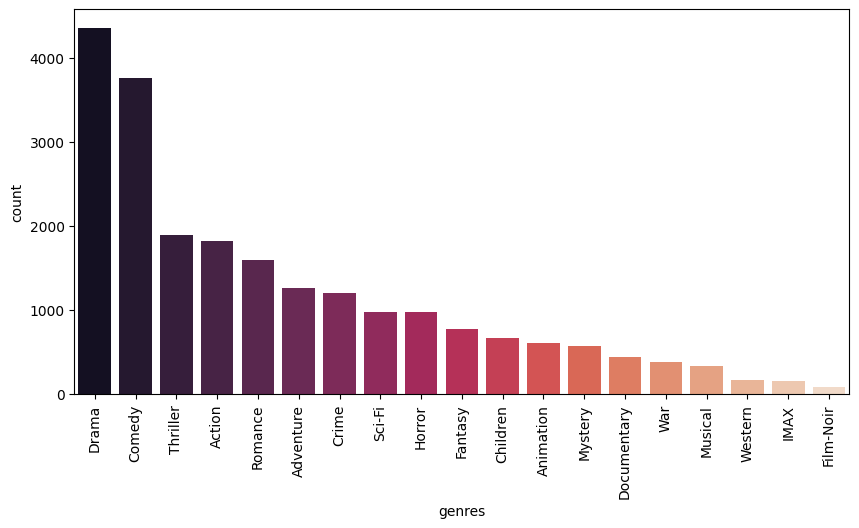

In [ ]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `Drama` y `Comedia` son los generos mas populares mientras que los `Westerns`, `IMAX`, and `Film-Noir` son los menos populares.

#### Extrayendo el año del titulo de las peliculas

Como lo mencionamos al inicio, nuestro dataset contiene en parentesis el año junto con el titulo de la pelicula, c.p.e GoldenEye (1995). Luego entonces, queremos utilizar el año de una pelicula como una caracteristica de las peliculas por lo que lo extrearemos del titulo y crearemos una columna `year` para almacenar este dato.


La siguiente funcion lleva a cabo esta tarea.
`extraer_año_titulo_pelicula()` toma el titulo y hace lo siguiente:

- genera una lista al dividir cada palabra con espacios (e.g., `["Golden", "Eye", "(1995)"]`)
- toma el ultimo elemento de la lista (e.g., `"(1995)"`)
- Si el elemento tiene parentesis `()` alrededor, estos se remueven(e.g., `"1995"`)
- convierte el año en un entero

In [ ]:
import re

def extraer_año_titulo_pelicula(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

Podemos validar esta funcion con la pelicula `"Golden Eye (1995)"`:

In [ ]:
title = "Golden Eye (1995)"
year = extraer_año_titulo_pelicula(title)
print(f"La pelicula {title} se estreno el año de {year}")
type(year)

La pelicula Golden Eye (1995) se estreno el año de 1995


int

La funcion `extract_year_from_title()` permite extraer el año del string por lo que ahora podemos aplicar esta funcion a todo el data frame de `movies` utilizando el metodo `apply ()` de Pandas.

In [ ]:
movies['year'] = movies['title'].apply(extraer_año_titulo_pelicula)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


#### Cuantos año distintos estan contenidos en nuestro dataset?


In [ ]:
unique_years = movies['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 106


Con este calculo rapido, nos percatamos que contamos con mas de 100 años en nuestro dataset. Lo que podemos hacer ahora es dividir nuestros datos en decadas para tener una idea en general de cuando fueron lanzadas las peliculas de nuestro dataset.

#### Cual fue la decada mas popular para estrenar una pelicula?

Analizemos el dataset para conocer el numero de peliculas contenidas.

In [ ]:
print(f"Numero total de peliculas en el dataset: {movies['movieId'].nunique()}")

Numero total de peliculas en el dataset: 9742


Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [ ]:
movies = movies[~movies['year'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el año:: {movies['movieId'].nunique()}")


Total de peliculas despues de eliminar aquellas con null en el año:: 9718


Esto nos dice que se eliminaron 24 peliculas que no contaba con un año de lanzamiento:

Existen dos formas de calcular la decada de un año:

1. convertir el año a string y remplazar el ultimo digito con un 0

2. redondear el año al decimo (10) proximo

In [ ]:
x = 1995

def calcular_decada(year):
    year = str(year)
    decade_prefix = year[0:3] # obtener los primeros 3 digitos de un año
    decade = f'{decade_prefix}0' # añadir un 0 al final
    return int(decade)

calcular_decada(x)

1990

In [ ]:
def redondear(year):
    return year - (year%10)

redondear(x)

1990

Ambas funciones `calcular_decada()` y `redondear()` cumplen con el objetivo de identificar la decada de un año.

Podemos aplicar cualquiera de ellas a todos los años de nuestro dataset `movies` y al mismo tiempo crearemos una columna llamada `decade`.


In [ ]:
movies['decade'] = movies['year'].apply(redondear)

### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las peliculas y las columnas las caracteristicas (generos y decadas)


Primero, debemos manipular la columna de `generos` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [ ]:
genres = list(contador_generos.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [ ]:
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los generos se representan como columnas con propiedades binarias. Ahora debemos asignar las distintas decadas a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [ ]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False


Lo siguiente es crear un nuevo dataframe con las propiedades de de decada y genero de las peliculas en `movie_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [ ]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
1,1,0,1,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,0,0,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,0,0,1,0,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False


El dataframe `movie_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (9718, 9718)


Esto nos indica que al evaluar la similitud de coseno del dataframe `movie_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre peliculas similares

Si por ejemplo queremos encontrar peliculas que sean similares a `Jumanji` en nuestro sistema de recomendacion, necesitamos saber el titulo de una pelicula en nuestro dataset.

Afortunadamente la pelicula esta listada como `'Jumanji (1995)'`. Sin embargo, si deletreamos mal el nombre u olvidamos incluir el año de su lanzamiento, el sistema no sabra que pelicula es a la que nos estamos refiriendo.

Con el fin de que nuestro sistema sea mas amigable para el usuario, utilizaremos un paquete llamado `fuzzywuzzy` que nos ayudara a encontrar el titulo de la pelicula mas parecido a partir del string que le pasemos.

Con base en esto, crearemos una funcion que se llame `encuentra_pelicula()` que implementa el algoritmo de matching de strings de `fuzzywuzzy` para hallar el titulo mas parecido a partir de un string ingresado por el usuario.

In [ ]:
from fuzzywuzzy import process

def encuentra_pelicula(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `Jumanji`

In [ ]:
title = encuentra_pelicula('jumnji')
print(f"El titulo correcto de la pelicula es: {title}:")

El titulo correcto de la pelicula es: Jumanji (1995):


Ahora que ya no nos preocupamos por escribir mal el titulo de una pelicula, lo que nos interesa es encontrar recomendaciones relevantes a partir de la pelicula que deseamos.

Deseamos encontrar el indice de la pelicula en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de indices de peliculas que encuentre el titulo de una pelicula y le asigne el indice que representa en nuestra matriz.

Crearemos un diccionario llamado `movie_idx` donde las llaves son los titulos de las peliculas y los valores son los indices de las peliculas.

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula Jumanji (1995) en la matriz movie_idx es: 1


Al usar el diccionario `movie_idx`, sabemos que Jumanji se representa por el indice 1 en nuestra matriz.

Ahora tratemos de encontrar las 10 peliculas mas similares a Jumanji.

In [ ]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso Jumanji). Podemos encontrar el titulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de titulo del dataframe `movies`.

In [ ]:
print(f"Por que miraste la pelicula {title}, te pueden interesar las siguientes {numero_recomendaciones} peliculas:")
movies['title'].iloc[similar_movies]

Por que miraste la pelicula Jumanji (1995), te pueden interesar las siguientes 10 peliculas:


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
1618    NeverEnding Story II: The Next Chapter, The (1...
8719                   The Cave of the Golden Rose (1991)
9565                            Gulliver's Travels (1996)
1357                                Borrowers, The (1997)
1565                                     Tall Tale (1995)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
Name: title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas.

In [ ]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_pelicula(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las peliculas recomendadas con base en la pelicula {title} son:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
obtener_recomendaciones_basadas_contenido('aladin', 5)

Las peliculas recomendadas con base en la pelicula Aladdin (1992) son:
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object


# Recomendaciones finales:

## Repite todos los pasos contenidos en este proyecto con el dataset de tu proyecto.

### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Paso 2: Cargando el dataset de calificaciones
amazon = pd.read_json("/content/drive/MyDrive/meta_Electronics.jsonl", lines=True)


amazon = amazon.sample(frac=0.01, random_state=42, ignore_index=True)
amazon.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Home Audio & Theater,iPhone 8 Lightning Adapter Headphone Metal Cas...,4.5,4,"[Toroidal Power Transformer, A/B Speaker outpu...",[NAD - C 372 - Integrated Amplifier Technical ...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],zerkar,"[Electronics, Car & Vehicle Electronics, Car E...","{'Manufacturer': 'zerkar', 'Is Discontinued By...",B000V4DOY4,NaN,NaN,NaN
1,Cell Phones & Accessories,Gear4 Angry Birds SpaceTouch Case for iPod 4G ...,4.4,6,"[Camera hole, Clip-On design, Full access to a...",[Protect your iPod with a design that is truly...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Gear4,"[Electronics, Portable Audio & Video, MP3 & MP...",{'Product Dimensions': '4.3 x 0.6 x 6.7 inches...,B007WPHXA6,NaN,NaN,NaN
2,All Electronics,Surface Pro 9 Pro 8 Docking Station Hub with 4...,3.9,29,[【Especially Designed for Surface Pro 9 Pro 8】...,[],39.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Rocketek,"[Electronics, Computers & Accessories, Laptop ...",{'Package Dimensions': '5.35 x 3.15 x 0.71 inc...,B0BN8DDG2Z,NaN,NaN,NaN
3,All Electronics,DriSentri 120W Speaker 3 Way Audio Frequency D...,4.1,13,"[Using overcurrent protection device, durable,...","[Features:, - Using overcurrent protection dev...",9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],DriSentri,"[Electronics, Home Audio, Home Audio Accessori...",{'Product Dimensions': '4.02 x 2.36 x 0.79 inc...,B09W5VRNDZ,NaN,NaN,NaN
4,All Electronics,USB Bluetooth 4.0 Adapter Dongle for PC Laptop...,3.7,9,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],ACSUN,[],{'Product Dimensions': '0.9 x 0.6 x 0.23 inche...,B07VHL6G2H,NaN,NaN,NaN


### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de considerar que las marcas de los electrodomesticos estan incompletas al igual que el user_attr,  por lo que debemos de limpiar los datos partiendo de las dos siguientes consideraciones:





In [5]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100 entries, 0 to 16099
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    15066 non-null  object 
 1   title            16100 non-null  object 
 2   average_rating   16100 non-null  float64
 3   rating_number    16100 non-null  int64  
 4   features         16100 non-null  object 
 5   description      16100 non-null  object 
 6   price            5272 non-null   object 
 7   images           16100 non-null  object 
 8   videos           16100 non-null  object 
 9   store            16009 non-null  object 
 10  categories       16100 non-null  object 
 11  details          16100 non-null  object 
 12  parent_asin      16100 non-null  object 
 13  bought_together  0 non-null      float64
 14  subtitle         10 non-null     object 
 15  author           9 non-null      object 
dtypes: float64(2), int64(1), object(13)
memory usage: 2.0+ MB


#Se eliminan las columnas de price, bought_together, subtitle y author ya que no son relevantes para el analisis y por su alto contenido de valores nulos.

In [6]:
#Eliminando las columnas user_attr y brand
amazon = amazon.drop(['price', 'bought_together', 'subtitle', 'author'], axis=1)

#### Calculemos cuantos categorias de productos contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada categoria en el dataset.

In [7]:
##### Calculemos cuantas categorias de productos hay en el dataset
from collections import Counter

contador_categorias = Counter(c for categories in amazon['categories'] for c in categories)
print(f"Existen {len(contador_categorias)} tipos de categorias de productos.")
contador_categorias


Existen 693 tipos de categorias de productos.


Counter({'Electronics': 14793,
         'Car & Vehicle Electronics': 708,
         'Car Electronics': 463,
         'Portable Audio & Video': 639,
         'MP3 & MP4 Player Accessories': 183,
         'Cases': 1249,
         'Computers & Accessories': 6441,
         'Laptop Accessories': 1320,
         'Docking Stations': 27,
         'Home Audio': 624,
         'Home Audio Accessories': 412,
         'Home Audio Crossovers & Parts': 4,
         'Crossover Parts': 4,
         'Security & Surveillance': 238,
         'Radio Scanners': 3,
         'Connectors & Adapters': 129,
         'Tablet Accessories': 1300,
         'Bags, Cases & Sleeves': 1469,
         'Computer Accessories & Peripherals': 1677,
         'Cables & Accessories': 543,
         'Cables & Interconnects': 542,
         'USB Cables': 267,
         'Computer Components': 946,
         'Internal Components': 685,
         'CPU Processors': 23,
         'USB Hubs': 30,
         'Power Accessories': 272,
         'AC Ada

#### Calculemos cuantos generos de peliculas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [8]:
print("Top 10 Categorias de Productos: \n", contador_categorias.most_common(10))

Top 10 Categorias de Productos: 
 [('Electronics', 14793), ('Computers & Accessories', 6441), ('Camera & Photo', 2551), ('Accessories', 1944), ('Computer Accessories & Peripherals', 1677), ('Bags, Cases & Sleeves', 1469), ('Laptop Accessories', 1320), ('Tablet Accessories', 1300), ('Cases', 1249), ('Television & Video', 1144)]


En el Top 10 de generos encontramos: "Computers", "All Electronics", "Camera & Photo", "Cell Phones & Accessories", "Home Audio & Theater", "Industrial & Scientific", "Car Electronics", "Tools & Home Improvement"y "Amazon Home".

<ipython-input-9-3f7e9da45fd8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='count', data=category_counts_df, palette='rocket')


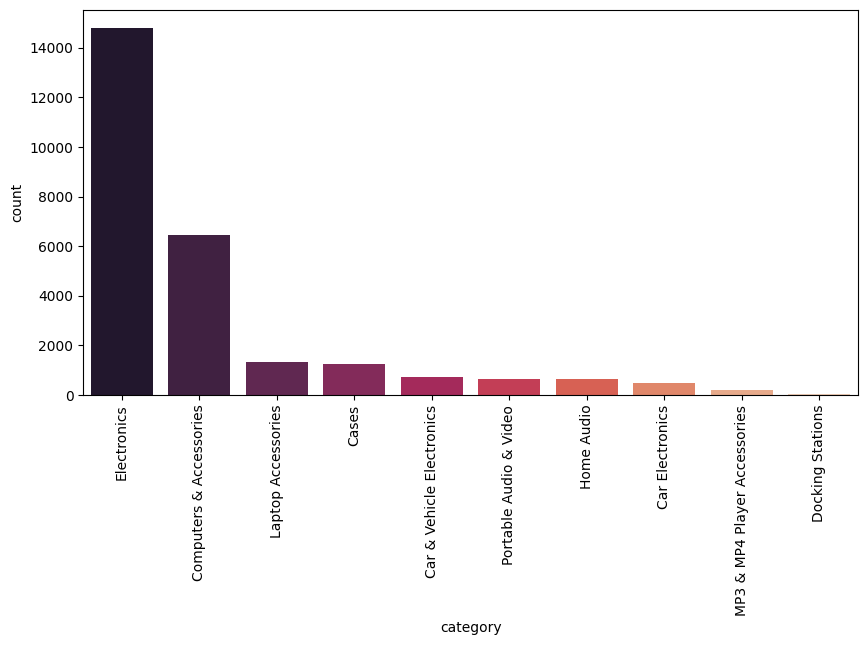

In [9]:
#Se grafican las primeras 10 categorias de productos y las ultimas 10

category_counts_df = pd.DataFrame([contador_categorias]).T.reset_index()
category_counts_df.columns = ['category', 'count']
category_counts_df = category_counts_df.head(10).sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='category', y='count', data=category_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()



<ipython-input-10-d7202dd1c465>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='count', data=category_counts_df, palette='rocket')


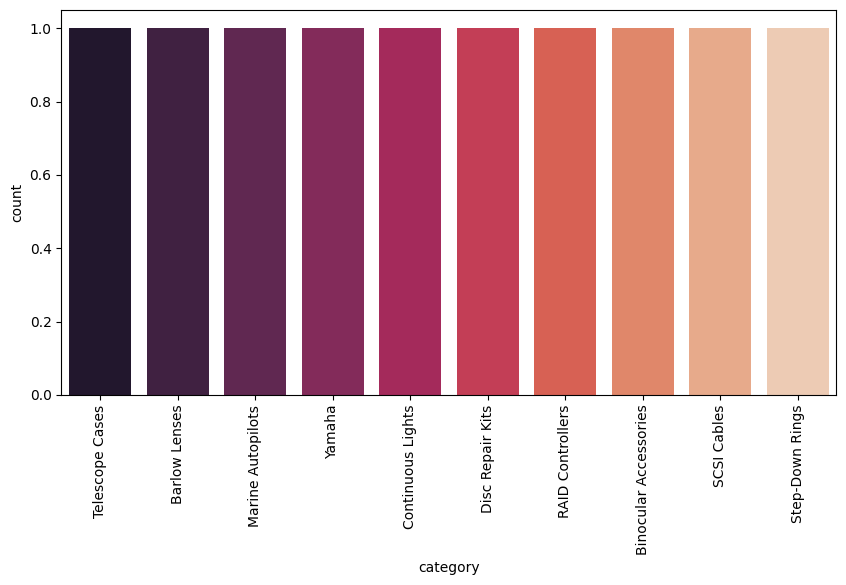

In [10]:
#Se grafican las ultimas 10 categorias de productos
category_counts_df = pd.DataFrame([contador_categorias]).T.reset_index()
category_counts_df.columns = ['category', 'count']
category_counts_df = category_counts_df.tail(10).sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='category', y='count', data=category_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, "Electronics" y "Computer & Accesories" son los generos mas populares mientras que "SCSI Cables" y "Step-Down Rings" son los menos populares.

In [11]:
#### Extrayendo el año de la descripcion de los productos

def extract_year_details(details):
    #Obtenemos Date First Available del diccionario
    date =details.get('Date First Available')
    if date:
        year = int(date[-4:])
        return year
    return None



In [12]:
year = extract_year_details(amazon['details'][1])
print(f"El producto {amazon['title'][0]} fue lanzado en el año {year}")

El producto iPhone 8 Lightning Adapter Headphone Metal Case Headphone Audio Adapter 2.4A Quick Charge Earphones Splitter - compatible with IOS 11 ZERKAR (Black-lightning^) fue lanzado en el año 2012


La funcion `extract_year_detail()` permite extraer el año del string por lo que ahora podemos aplicar esta funcion a todo el data frame de `amazon` utilizando el metodo `apply ()` de Pandas.

In [13]:
amazon['year'] = amazon['details'].apply(extract_year_details)
amazon.head()

,main_category,title,average_rating,rating_number,features,description,images,videos,store,categories,details,parent_asin,year
0,Home Audio & Theater,iPhone 8 Lightning Adapter Headphone Metal Cas...,4.5,4,"[Toroidal Power Transformer, A/B Speaker outpu...",[NAD - C 372 - Integrated Amplifier Technical ...,[{'thumb': 'https://m.media-amazon.com/images/...,[],zerkar,"[Electronics, Car & Vehicle Electronics, Car E...","{'Manufacturer': 'zerkar', 'Is Discontinued By...",B000V4DOY4,2008.0
1,Cell Phones & Accessories,Gear4 Angry Birds SpaceTouch Case for iPod 4G ...,4.4,6,"[Camera hole, Clip-On design, Full access to a...",[Protect your iPod with a design that is truly...,[{'thumb': 'https://m.media-amazon.com/images/...,[],Gear4,"[Electronics, Portable Audio & Video, MP3 & MP...",{'Product Dimensions': '4.3 x 0.6 x 6.7 inches...,B007WPHXA6,2012.0
2,All Electronics,Surface Pro 9 Pro 8 Docking Station Hub with 4...,3.9,29,[【Especially Designed for Surface Pro 9 Pro 8】...,[],[{'thumb': 'https://m.media-amazon.com/images/...,[],Rocketek,"[Electronics, Computers & Accessories, Laptop ...",{'Package Dimensions': '5.35 x 3.15 x 0.71 inc...,B0BN8DDG2Z,2023.0
3,All Electronics,DriSentri 120W Speaker 3 Way Audio Frequency D...,4.1,13,"[Using overcurrent protection device, durable,...","[Features:, - Using overcurrent protection dev...",[{'thumb': 'https://m.media-amazon.com/images/...,[],DriSentri,"[Electronics, Home Audio, Home Audio Accessori...",{'Product Dimensions': '4.02 x 2.36 x 0.79 inc...,B09W5VRNDZ,2022.0
4,All Electronics,USB Bluetooth 4.0 Adapter Dongle for PC Laptop...,3.7,9,[],[],[{'thumb': 'https://m.media-amazon.com/images/...,[],ACSUN,[],{'Product Dimensions': '0.9 x 0.6 x 0.23 inche...,B07VHL6G2H,2019.0


#### Cuantos año distintos estan contenidos en nuestro dataset?

In [14]:
unique_years = amazon['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 26


como se puede observar, el dataset contiene 42 años distintos. Lo que podemos hacer ahora es dividir nuestros datos en decadas para tener una idea en general de cuando fueron lanzadas las peliculas de nuestro dataset.

#### Cual fue la decada mas popular para estrenar un producto?

Analizemos el dataset para conocer el numero de productos contenidos.

In [15]:
print(f"Numero total de productos en el dataset: {amazon['parent_asin'].nunique()}")

Numero total de productos en el dataset: 16100


Limpiamos todos los productos que contengan un `null` en el año.


In [16]:
amazon = amazon[~amazon['year'].isnull()]
print(f"Total de productos despues de eliminar aquellos con null en el año: {amazon['parent_asin'].nunique()}")

Total de productos despues de eliminar aquellos con null en el año: 15060


Se puede observar que se eliminaron 100,265 productos que no contaban con un año de lanzamiento:

#Encontramos la decada a la que pertenece cada producto

In [17]:
x = 2019

def calculate_decade(year):
    year = str(year)
    decade_prefix = year[0:3]
    decade = f'{decade_prefix}0'
    return int(decade)

calculate_decade(x)


2010

In [18]:
def round_year(year):
    return year - (year%10)

round_year(x)

2010

In [19]:
#Aplicamos la funcion round_year a la columna year
amazon['decade'] = amazon['year'].apply(round_year)
amazon.head()

<ipython-input-19-7a3df3f0b945>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon['decade'] = amazon['year'].apply(round_year)


,main_category,title,average_rating,rating_number,features,description,images,videos,store,categories,details,parent_asin,year,decade
0,Home Audio & Theater,iPhone 8 Lightning Adapter Headphone Metal Cas...,4.5,4,"[Toroidal Power Transformer, A/B Speaker outpu...",[NAD - C 372 - Integrated Amplifier Technical ...,[{'thumb': 'https://m.media-amazon.com/images/...,[],zerkar,"[Electronics, Car & Vehicle Electronics, Car E...","{'Manufacturer': 'zerkar', 'Is Discontinued By...",B000V4DOY4,2008.0,2000.0
1,Cell Phones & Accessories,Gear4 Angry Birds SpaceTouch Case for iPod 4G ...,4.4,6,"[Camera hole, Clip-On design, Full access to a...",[Protect your iPod with a design that is truly...,[{'thumb': 'https://m.media-amazon.com/images/...,[],Gear4,"[Electronics, Portable Audio & Video, MP3 & MP...",{'Product Dimensions': '4.3 x 0.6 x 6.7 inches...,B007WPHXA6,2012.0,2010.0
2,All Electronics,Surface Pro 9 Pro 8 Docking Station Hub with 4...,3.9,29,[【Especially Designed for Surface Pro 9 Pro 8】...,[],[{'thumb': 'https://m.media-amazon.com/images/...,[],Rocketek,"[Electronics, Computers & Accessories, Laptop ...",{'Package Dimensions': '5.35 x 3.15 x 0.71 inc...,B0BN8DDG2Z,2023.0,2020.0
3,All Electronics,DriSentri 120W Speaker 3 Way Audio Frequency D...,4.1,13,"[Using overcurrent protection device, durable,...","[Features:, - Using overcurrent protection dev...",[{'thumb': 'https://m.media-amazon.com/images/...,[],DriSentri,"[Electronics, Home Audio, Home Audio Accessori...",{'Product Dimensions': '4.02 x 2.36 x 0.79 inc...,B09W5VRNDZ,2022.0,2020.0
4,All Electronics,USB Bluetooth 4.0 Adapter Dongle for PC Laptop...,3.7,9,[],[],[{'thumb': 'https://m.media-amazon.com/images/...,[],ACSUN,[],{'Product Dimensions': '0.9 x 0.6 x 0.23 inche...,B07VHL6G2H,2019.0,2010.0


### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las peliculas y las columnas las caracteristicas (generos y decadas)


Primero, debemos manipular la columna de `main_category` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [20]:
categories = list(contador_categorias.keys())

for c in categories:
    #Main category solo contiene una categoria
    amazon[c] = amazon['categories'].transform(lambda x: int(c in x))

<ipython-input-20-a016d2117c04>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amazon[c] = amazon['categories'].transform(lambda x: int(c in x))
<ipython-input-20-a016d2117c04>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amazon[c] = amazon['categories'].transform(lambda x: int(c in x))
<ipython-input-20-a016d2117c04>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Ahora debemos asignar las distintas decadas a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [21]:
amazon_decades = pd.get_dummies(amazon['decade'])
amazon_decades.head()

,1970.0,1990.0,2000.0,2010.0,2020.0
0,False,False,True,False,False
1,False,False,False,True,False
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,True,False


In [22]:
amazon_features = pd.concat([amazon[categories], amazon_decades], axis=1)
amazon_features.head()

,Electronics,Car & Vehicle Electronics,Car Electronics,Portable Audio & Video,MP3 & MP4 Player Accessories,Cases,Computers & Accessories,Laptop Accessories,Docking Stations,Home Audio,...,Disc Repair Kits,RAID Controllers,Binocular Accessories,SCSI Cables,Step-Down Rings,1970.0,1990.0,2000.0,2010.0,2020.0
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,False,False,True,False,False
1,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,False,False,False,True,False
2,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,False,False,False,False,True
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,False,False,False,False,True
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,False,False,False,True,False


### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

amazon_cosine_sim = cosine_similarity(amazon_features, amazon_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {amazon_cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (15060, 15060)


### Desarrollando una funcion que encuentre productos similares

In [24]:
!pip install fuzzywuzzy

In [25]:
from fuzzywuzzy import process

def find_product(title):
    all_titles = amazon['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [26]:
title = find_product('Echo Dot')
print(f"El producto correcto es: {title}")

El producto correcto es: Echo Dot Wall Mount for Echo Dot 3rd Gen (White)


#Se crea un diccionario llamado `product_idx` donde las llaves son los titulos de los productos y los valores son los indices de los productos.

In [27]:
product_idx = dict(zip(amazon['title'], list(amazon.index)))
idx = product_idx[title]
print(f"El indice del producto {title} en la matriz product_idx es: {idx}")

El indice del producto Echo Dot Wall Mount for Echo Dot 3rd Gen (White) en la matriz product_idx es: 9267


#Buscamos los 10 productos mas similares a un producto en especifico.

In [28]:
numero_recomendaciones=10
sim_scores = list(enumerate(amazon_cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_products = [i[0] for i in sim_scores]

In [29]:
print(f"Por que compraste el producto {title}, te pueden interesar los siguientes {numero_recomendaciones} productos:")
amazon['title'].iloc[similar_products]

Por que compraste el producto Echo Dot Wall Mount for Echo Dot 3rd Gen (White), te pueden interesar los siguientes 10 productos:


2551     Motor Trend Over-The-Head Bluetooth Headset wi...
6553     Insten Overhead Headset with Built in Micropho...
9907     Coby CVH56 Folding Lightweight Stereo Headphon...
12588    Koss KSC24 Portable Behind-the-neck Stereophon...
9256     UNIVERSAL CELL PHONE STEREO HEADSET EARPHONES ...
10773                                Jabra EarGels - Small
11934    Plantronics Voyager 520 Bluetooth Headset (758...
12531      Plantronics Pulsar 590 Bluetooth Stereo Headset
14098      Sharper Image(tm) Noise Cancellation Headphones
14265                               500XL Desktop Speakers
Name: title, dtype: object

Probamos nuestro sistema con otros titulos de productos.

In [32]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = find_product(title_string)
    idx = product_idx[title]
    sim_scores = list(enumerate(amazon_cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_products = [i[0] for i in sim_scores]
    print(f"Los productos recomendados con base en el producto {title} son:")
    print(amazon['title'].iloc[similar_products])

In [33]:
obtener_recomendaciones_basadas_contenido('Echo Dot', 5)

Los productos recomendados con base en el producto Echo Dot Wall Mount for Echo Dot 3rd Gen (White) son:
2551     Motor Trend Over-The-Head Bluetooth Headset wi...
6553     Insten Overhead Headset with Built in Micropho...
9907     Coby CVH56 Folding Lightweight Stereo Headphon...
12588    Koss KSC24 Portable Behind-the-neck Stereophon...
9256     UNIVERSAL CELL PHONE STEREO HEADSET EARPHONES ...
Name: title, dtype: object
